In [1]:
import os
import sys
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import tqdm
from abc import ABCMeta, abstractmethod, abstractproperty
from copy import copy
from collections import Counter
%matplotlib inline
plt.style.use("ggplot")
%load_ext autoreload
%autoreload 2

## Exercise 5.4 使用off policy估计black jacket value

In [2]:
class Env(metaclass=ABCMeta):
    def __init__(self,rng_seed=random.randint(0,1000)):
        self.rng = np.random.RandomState(rng_seed)
    
    @staticmethod
    def get_actions(self):
        pass
    
    @abstractmethod
    def step(self,action):
        pass
        # return done,observation,reward,extra
        
    @abstractmethod
    def get_observation(self):
        pass
    
    @abstractmethod
    def observation_to_state(self,observation):
        pass
    
    @abstractmethod
    def get_history(self,):
        pass
    
    @abstractmethod
    def get_state_shape(self):
        pass
        
    @abstractmethod
    def reset(self):
        pass
    
class BlackJackEnv(Env):
    def __init__(self,dealer_stick=17,bust_threshold=21):
        super().__init__()
        self.dealer_stick = dealer_stick
        self.cards = [1,2,3,4,5,6,7,8,9,10,10,10,10]
        self.reset()
        self.actions = ["stick","hit"]
        self.bust_threshold = bust_threshold
    
    def get_actions(self):
        return self.actions
    
    def dealer_play(self):
        while self.get_max_number(self.dealer_cards) < self.dealer_stick:
            self.dealer_cards.append(self.get_random_card())
    
    def get_reward(self):
        dealer_num = self.get_max_number(self.dealer_cards)
        player_num = self.get_max_number(self.player_cards)
        if player_num > self.bust_threshold:
            reward = -1
        elif dealer_num > self.bust_threshold:
            reward = 1
        else:
            if dealer_num > player_num:
                reward = -1
            elif dealer_num == player_num:
                reward = 0
            else:
                # dealer_num < player_num
                reward = 1
        return reward
    
    def step(self,action):
        assert(action in self.actions)
        # nature
        if len(self.player_cards) == 2 and self.get_max_number(self.player_cards) == self.bust_threshold:
            if self.get_max_number(self.dealer_cards) == self.bust_threshold:
                return True,self.get_observation(),0,None
            else:
                return True,self.get_observation(),1,None
        self.action_history.append(action)
        
        if action == "stick":
            self.dealer_play()
            reward = self.get_reward()
            return True,self.get_observation(),reward,None
        elif action == "hit":
            self.player_cards.append(self.get_random_card())
            if self.get_max_number(self.player_cards) < self.bust_threshold:
                return False,self.get_observation(),0,None
            elif self.get_max_number(self.player_cards) == self.bust_threshold:
                return True,self.get_observation(),1,None
            else:
                # player busted
                return True,self.get_observation(),-1,None
        # return done,observation,reward,extra
    
    def has_unused_ace(self,cards):
        if 1 in cards and sum(cards) + 10 <= self.bust_threshold:
            return True
        else:
            return False
    
    def get_max_number(self,cards):
        sumcards = sum(cards)
        if self.has_unused_ace(cards):
            return sumcards + 10
        else:
            return sumcards
    
    def get_max_unbusted_number(self,cards):
        sumcards = sum(cards)
        assert(sumcards <= self.bust_threshold)
        if self.has_unused_ace(cards):
            return sumcards + 10
        else:
            return sumcards
    
    def get_observation(self):
        return (self.has_unused_ace(self.player_cards),self.player_cards,self.dealer_showcard)
    
    def observation_to_state(self,observation):
        unused_ace,player_cards,dealer_showcard = observation
        return int(unused_ace),self.get_max_unbusted_number(self.player_cards),dealer_showcard
        
    def get_state_shape(self):
        return [2,22,11]
        
    def get_random_card(self):
        return self.rng.choice(self.cards)
    
    def reset(self):
        self.player_cards = [self.get_random_card() for i in range(2)]
        
        self.dealer_cards = [self.get_random_card() for i in range(2)]
        self.dealer_showcard = self.dealer_cards[0]
        self.action_history = []
    
    def get_history(self):
        str_player =  f"player [{self.player_cards[:2]}] -> {self.player_cards[2:]} dealer [{self.dealer_cards[:2]}] -> {self.dealer_cards[2:]}"
        return "{} \n {}".format(str_player,"->".join(self.action_history))

### 21点环境使用示例

In [4]:
bje = BlackJackEnv()

In [5]:
bje.reset()
print(bje.get_observation())
while True:
    print(bje.get_observation())
    print(bje.observation_to_state(bje.get_observation()))
    done,observation,reward,extra = bje.step(random.choice(["hit","stick"]))
    if done:
        break 
print(reward)
print(bje.get_history())

(False, [9, 9], 7)
(False, [9, 9], 7)
(0, 18, 7)
-1
player [[9, 9]] -> [9] dealer [[7, 3]] -> [] 
 hit


### off policy 环境

In [17]:
class Strategy(metaclass=ABCMeta):
    def __init__(self,env:Env):
        self.env = env
    
    @staticmethod
    def action_probs(self):
        pass
    
class ThresholdBlackjackStrategy(Strategy):
    def __init__(self,env:Env,stick_threshold=20):
        self.env = env
        self.stick_threshold = stick_threshold
    
    def action_probs(self):
        if self.env.get_max_unbusted_number(self.env.player_cards) >= self.stick_threshold:
            return {
                "stick" : 1,
                "hit"   : 0
            }
        else:
            return {
                "stick" : 0,
                "hit"   : 1
            }
        
class EqualProbBlackjackStrategy(Strategy):
    def __init__(self,env:Env):
        self.env = env
    
    def action_probs(self):
        return {
            "stick" : 0.5,
            "hit"   : 0.5
        }

In [116]:
class OffPolicyValueEstimator(metaclass=ABCMeta):
    def __init__(self,env:Env,target_strategy:Strategy,behavior_strategy:Strategy):
        self.env = env
        self.target_strategy = target_strategy
        self.behavior_strategy = behavior_strategy
        self.values = np.zeros(self.env.get_state_shape(),dtype=np.float)
    
    @abstractmethod
    def set_env_random_initial_state(self):
        pass
    
    @abstractmethod
    def estimate_value(self,steps):
        pass

class BlackjackGivenStateEstimator(OffPolicyValueEstimator):
    def __init__(self,env:Env,target_strategy:Strategy,behavior_strategy:Strategy,
                 player_cards=[1,2],dealer_card=2):
        super().__init__(env,target_strategy,behavior_strategy)
        self.values_sum = np.zeros(self.env.get_state_shape(),dtype=np.float)
        self.values_count = np.zeros(self.env.get_state_shape(),dtype=np.float)
        self.player_cards = player_cards
        self.dealer_card = dealer_card
        
    def set_env_random_initial_state(self):
        self.env.reset()
        self.env.player_cards = copy(self.player_cards)
        
        self.env.dealer_cards[0] = copy(self.dealer_card)
        self.env.dealer_showcard = copy(self.dealer_card)
        
    @abstractmethod
    def backprog(self,infos):
        pass
        
    def monte_carlo_run(self):
        self.set_env_random_initial_state()
        states = []
        actions = []
        rewards = []
        
        prob_pis = []
        prob_bes = []
        while True:
            state = self.env.observation_to_state(self.env.get_observation())
            states.append(state)

            nextBehaviorProbs = self.behavior_strategy.action_probs()
            nextTargetProbs = self.target_strategy.action_probs()
            
            nextstep = np.random.choice(list(nextBehaviorProbs.keys()),p=list(nextBehaviorProbs.values()))
            
            prob_bes.append(nextBehaviorProbs[nextstep])
            prob_pis.append(nextTargetProbs[nextstep])
            
            done,observation,reward,extra = self.env.step(nextstep)
            actions.append(nextstep)
            rewards.append(reward)
            if done:
                break
        
        self.backprog((states,rewards,prob_pis,prob_bes))
        
    def estimate_value(self,steps):
        for one_step in tqdm.tqdm(range(steps)):
            self.monte_carlo_run()
        self.values = self.values_sum / (self.values_count + 1e-6)
        
        
class BlackjackOrdinaryEstimator(BlackjackGivenStateEstimator):
    def __init__(self,env:Env,target_strategy:Strategy,behavior_strategy:Strategy,
                 player_cards=[1,2],dealer_card=2):
        super().__init__(env,target_strategy,behavior_strategy,player_cards,dealer_card)
        self.log_values = []
        
    def backprog(self,infos):
        (states,rewards,prob_pis,prob_bes) = infos
        # value calculation
        G = 0
        
        probx_pi = 1
        probx_be = 1
        
        for one_state,one_reward,one_prob_pi,one_prob_be in zip(states[::-1],rewards[::-1],prob_pis[::-1],prob_bes[::-1]):
            G = G + one_reward
            
            probx_pi *= one_prob_pi
            probx_be *= one_prob_be
            
            assert(probx_be != 0)
            
            pt = probx_pi / probx_be
            
            self.values_count[one_state] += 1
            self.values_sum[one_state] += (G * pt)
        self.log_values.append(self.values_sum[1,13,2] / (self.values_count[1,13,2] + 1e-6))
            
class BlackjackWeightedEstimator(BlackjackGivenStateEstimator):
    def __init__(self,env:Env,target_strategy:Strategy,behavior_strategy:Strategy,
                 player_cards=[1,2],dealer_card=2):
        super().__init__(env,target_strategy,behavior_strategy,player_cards,dealer_card)
        self.log_values = []
        
    def backprog(self,infos):
        (states,rewards,prob_pis,prob_bes) = infos
        # value calculation
        G = 0
        
        probx_pi = 1
        probx_be = 1
        
        for one_state,one_reward,one_prob_pi,one_prob_be in zip(states[::-1],rewards[::-1],prob_pis[::-1],prob_bes[::-1]):
            G = G + one_reward
            
            probx_pi *= one_prob_pi
            probx_be *= one_prob_be
            
            assert(probx_be != 0)
            
            pt = probx_pi / probx_be
            
            self.values_count[one_state] += pt
            self.values_sum[one_state] += (G * pt)
        self.log_values.append(self.values_sum[1,13,2] / (self.values_count[1,13,2] + 1e-6))

In [117]:
blackJackEnv = BlackJackEnv()
thresholdBlackjackStrategy = ThresholdBlackjackStrategy(blackJackEnv)
equalProbBlackjackStrategy = EqualProbBlackjackStrategy(blackJackEnv)
blackjackOrdinaryEstimator = BlackjackOrdinaryEstimator(blackJackEnv,thresholdBlackjackStrategy,equalProbBlackjackStrategy)

In [118]:
blackjackOrdinaryEstimator.estimate_value(100000)

100%|██████████| 100000/100000 [00:23<00:00, 4329.76it/s]


In [119]:
blackjackOrdinaryEstimator.values[1,13,2]

-0.2671199999973288

In [123]:
blackJackEnv = BlackJackEnv()
thresholdBlackjackStrategy = ThresholdBlackjackStrategy(blackJackEnv)
equalProbBlackjackStrategy = EqualProbBlackjackStrategy(blackJackEnv)
blackjackWeightedEstimator = BlackjackWeightedEstimator(blackJackEnv,thresholdBlackjackStrategy,equalProbBlackjackStrategy)

In [124]:
blackjackWeightedEstimator.estimate_value(100000)

100%|██████████| 100000/100000 [00:20<00:00, 4956.02it/s]


In [125]:
blackjackWeightedEstimator.values[1,13,2]

-0.25837193640942013

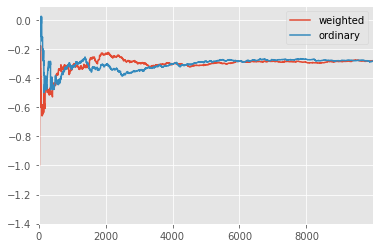

In [128]:
pd.DataFrame({
    "weighted":blackjackWeightedEstimator.log_values[:10000],
    "ordinary":blackjackOrdinaryEstimator.log_values[:10000]
}).plot()